# Results 2b: Similarity Analysis

In [1]:
import os
import numpy as np
from pandas import read_csv
from tqdm import tqdm

## Load reject data.
metrics = read_csv(os.path.join('data','metrics.csv'))

## Section 1: Metric Correspondence

In [5]:
## Define variables of interest.
cols = ['infreq','isd','reliability','mahalanobis','survey_rt','key_var','choice_var','wsls','task_rt']

## Precompute lower triangular indices.
ix = np.tril_indices(len(cols), k=-1)

## Precompute space for results.
tril = np.zeros((ix[0].size, 2))
fwer = np.zeros((ix[0].size, 2))

#### 1.1 Monotonic Dependence (Unthresholded)

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Compute and store true lower diagonal.
tril[:,0] = metrics[cols].corr(method='spearman').values[ix]

## Preallocate space.
max_rho = np.zeros(n_iter)

## Main loop.
for i in tqdm(range(n_iter)):
    
    ## Permute DataFrame.
    permuted = metrics[cols].apply(np.random.permutation).copy()
    
    ## Compute correlation matrix.
    permuted = permuted.corr(method='spearman').values[ix]
    
    ## Store.
    max_rho[i] = np.abs(permuted).max()
    
## Compute adjusted p-values.
fwer[:,0] = ((np.abs(tril[:,0]) <= max_rho[:,np.newaxis]).sum(axis=0) + 1) / (n_iter + 1)

100%|██████████| 5000/5000 [00:11<00:00, 431.43it/s]


#### 1.2 Rejection Similarity (Thresohold = 10%) 

In [7]:
from scipy.spatial.distance import dice

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define quantile.
q = 0.10

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Threshold parameters. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Copy reject DataFrame.
thresh = metrics[cols].copy()

## Threshold variables.
thresh['infreq'] = np.where( thresh['infreq'] > 0, 1, 0 )
thresh['isd'] = np.where( thresh['isd'] > thresh['isd'].quantile(1-q), 1, 0 )
thresh['reliability'] = np.where( thresh['reliability'] < thresh['reliability'].quantile(q), 1, 0 )
thresh['mahalanobis'] = np.where( thresh['mahalanobis'] > thresh['mahalanobis'].quantile(1-q), 1, 0 )
thresh['survey_rt'] = np.where( thresh['survey_rt'] < thresh['survey_rt'].quantile(q), 1, 0 )
thresh['key_var'] = np.where( thresh['key_var'] > thresh['key_var'].quantile(1-q), 1, 0 )
thresh['choice_var'] = np.where( thresh['choice_var'] > thresh['choice_var'].quantile(1-q), 1, 0 )
thresh['wsls'] = np.where( thresh['wsls'] < thresh['wsls'].quantile(q), 1, 0 )
thresh['task_rt'] = np.where( thresh['task_rt'] > thresh['task_rt'].quantile(1-q), 1, 0 )

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Compute and store true lower diagonal.
tril[:,1] = 1 - thresh[cols].corr(method=dice).values[ix]

## Preallocate space.
max_rho = np.zeros(n_iter)

## Main loop.
for i in tqdm(range(n_iter)):
    
    ## Permute DataFrame.
    permuted = thresh[cols].apply(np.random.permutation).copy()
    
    ## Compute correlation matrix.
    permuted = 1 - permuted.corr(method=dice).values[ix]
    
    ## Store.
    max_rho[i] = np.abs(permuted).max()
    
## Compute adjusted p-values.
fwer[:,1] = ((np.abs(tril[:,1]) <= max_rho[:,np.newaxis]).sum(axis=0) + 1) / (n_iter + 1)

100%|██████████| 5000/5000 [00:20<00:00, 240.55it/s]


## Section 2: Plotting

#### 2.1 Main Figure

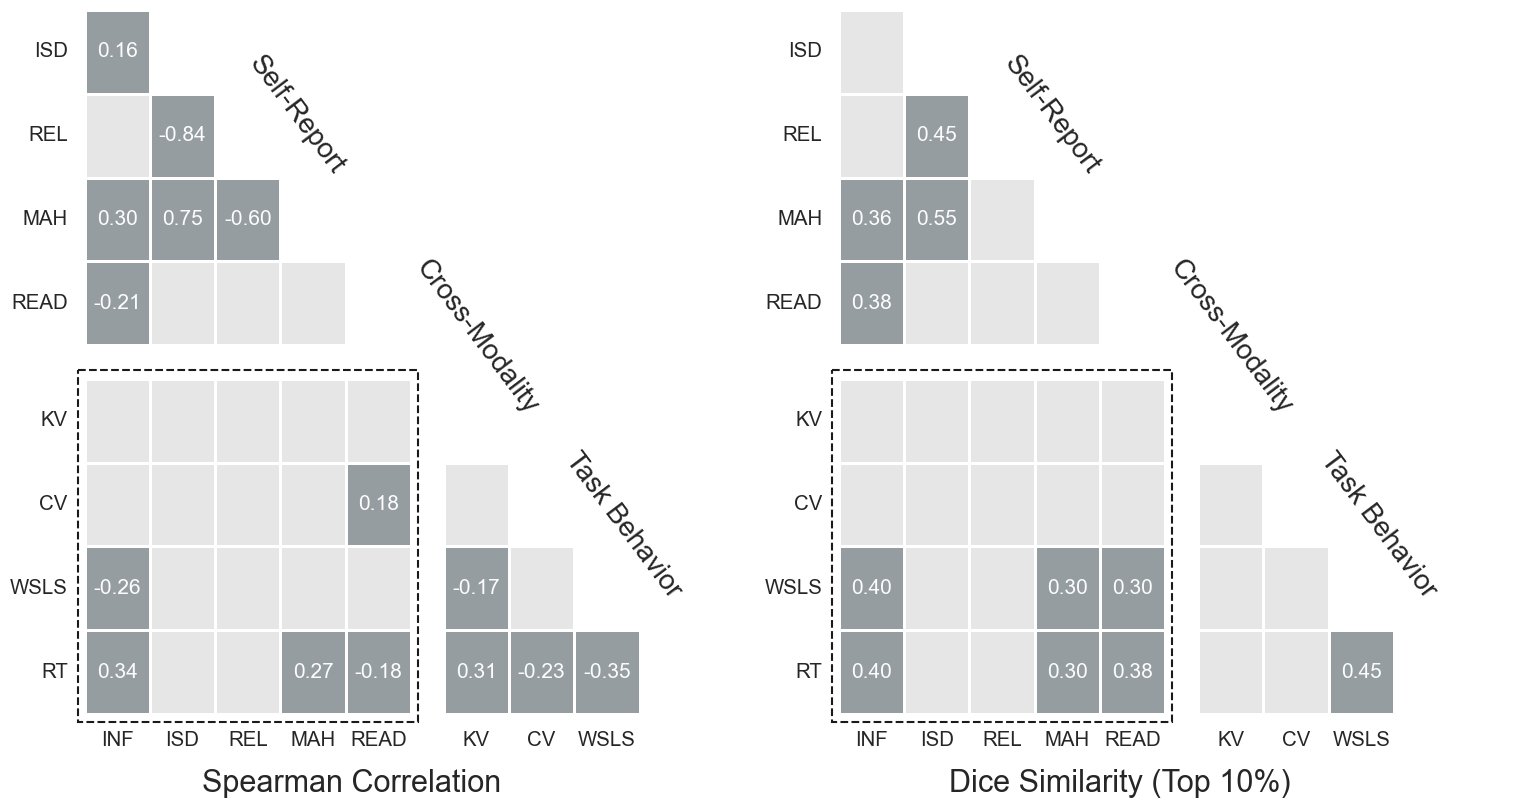

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define canvas.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(16,8))
                         
## Initialize grid.
gs = fig.add_gridspec(nrows=1, ncols=2, left=0.05, right=0.95, top=0.98, bottom=0.10, wspace=0.1, hspace=0.0)

## Initialize panels.
left_panel  = gs[0].subgridspec(nrows=2, ncols=2, wspace=0.1, hspace=0.1)
right_panel = gs[1].subgridspec(nrows=2, ncols=2, wspace=0.1, hspace=0.1)

## Define features.
cmap = ListedColormap(['#de425b','0.9','#959da1'])
titles = ['Spearman Correlation', 'Dice Similarity (Top 10%)']
annot_color = '0.99'
labelpad = 6

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for k, panel in enumerate([left_panel, right_panel]):

    ## Initialize correlation matrix.
    corr = np.zeros((8,10))
    corr[np.tril_indices_from(corr, k=0)] = np.where(fwer[:,k] < 0.05, tril[:,k], 0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Self-report correlations.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Initialize axis.
    ax = plt.subplot(panel[0,0])

    ## Plot correlations.
    arr = corr[:4,:5]
    sns.heatmap(np.abs(np.sign(arr)), cmap=cmap, cbar=False, center=0, linecolor='w', linewidths=1, 
                xticklabels=[], mask=np.triu(np.ones_like(arr), k=1), ax=ax)

    ## Add annotations.
    for i, j in np.array(np.where(arr)).T:
        ax.text(j+0.5, i+0.5, '%0.2f' %arr[i,j], ha='center', va='center', fontsize=15, color=annot_color)

    ## Add labels.
    yticklabels = ['ISD','REL','MAH','READ'] # if not k else ['','','','']
    ax.set_yticklabels(yticklabels, rotation=0, ha='right', va='center')
    ax.tick_params(axis='both', which='major', pad=labelpad)
        
    ## Category annotation.
    xytext = [(3.25,1.25), (3.25,1.25)]
    ax.annotate('Self-Report', (0,0), xytext=xytext[k], xycoords='data', rotation=-53,
                fontsize=20, ha='center', va='center')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Task correlations.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Initialize axis.
    ax = plt.subplot(panel[1,1])

    ## Plot correlations.
    arr = corr[4:,5:]
    sns.heatmap(np.abs(np.sign(arr)), cmap=cmap, cbar=False, center=0, linecolor='w', linewidths=1,
                yticklabels=[], mask=np.triu(np.ones_like(arr), k=0), ax=ax)

    ## Add annotations.
    for i, j in np.array(np.where(arr)).T:
        ax.text(j+0.5, i+0.5, '%0.2f' %arr[i,j], ha='center', va='center', fontsize=15, color=annot_color)

    ## Add labels.
    ax.set_xticklabels(['KV','CV','WSLS','',''], rotation=0, ha='center', va='top')
    ax.tick_params(axis='both', which='major', pad=labelpad)
        
    ## Add title.
    ax.annotate(titles[k], (0,0), (0.22 if not k else 0.70, 0.04), xycoords='figure fraction', 
                fontsize=22, ha='center', va='top')
    
    ## Within tasks.
    xytext = [(2.75,1.75), (2.75,1.75)]
    ax.annotate('Task Behavior', (0,0), xytext=xytext[k], xycoords='data', rotation=-53,
                fontsize=20, ha='center', va='center')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Joint correlations.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Initialize axis.
    ax = plt.subplot(panel[1,0])

    ## Plot correlations.
    arr = corr[4:,:5]
    sns.heatmap(np.abs(np.sign(arr)), cmap=cmap, cbar=False, center=0, linecolor='w', linewidths=1, ax=ax)

    ## Add annotations.
    for i, j in np.array(np.where(arr)).T:
        ax.text(j+0.5, i+0.5, '%0.2f' %arr[i,j], ha='center', va='center', fontsize=15, color=annot_color)

    ## Add labels.
    yticklabels = ['KV','CV','WSLS','RT'] # if not k else ['','','','']
    ax.set_yticklabels(yticklabels, rotation=0, ha='right', va='center')
    ax.set_xticklabels(['INF','ISD','REL','MAH','READ'], rotation=0, ha='center', va='top')
    ax.tick_params(axis='both', which='major', pad=labelpad)
    
    ## Add border.
    border = Rectangle((-0.1,-0.1), 5.2, 4.2, fill=False, linewidth=1.5, linestyle='--', edgecolor='k')
    border = ax.add_patch(border)
    border.set_clip_on(False)
        
    ## Category annotation.
    xytext = [(6.0,-0.5), (6.0,-0.5)]
    ax.annotate('Cross-Modality', (0,0), xytext=xytext[k], xycoords='data', rotation=-53,
                fontsize=20, ha='center', va='center')
    
## Save figure.
plt.savefig(os.path.join('figures','repl_02b.png'), dpi=180, transparent=True)

#### 2.2 Supplementary Tables

In [9]:
from pandas import DataFrame

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define tables.
tables = ['Spearman Correlation', 'Dice Similarity (Top 10%)']

## Define columns.
columns = ['INF','ISD','REL','MAH','READ','VAR','ACC','WSLS','RT']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for i, table in enumerate(tables):
    
    print(f'Constructing Table {i+1}: {table}.')

    ## Initialize correlation matrix.
    corr = np.identity(len(columns))
    corr = np.where(corr, '-', '').astype('<U16')

    ## Add lower diagonal elements.
    fmt = lambda r, p: '%0.3f*' %r if p < 0.05 else '%0.3f' %r
    corr[ix] = [fmt(r,p) for r, p in zip(tril[:,i], fwer[:,i])]

    ## Convert to DataFrame.
    corr = DataFrame(corr, index=columns, columns=columns)

    ## Print LaTeX.
    print(corr.to_latex())

Constructing Table 1: Spearman Correlation.
\begin{tabular}{llllllllll}
\toprule
{} &      INF &      ISD &      REL &     MAH &     READ &      VAR &      ACC &     WSLS & RT \\
\midrule
INF  &        - &          &          &         &          &          &          &          &    \\
ISD  &   0.164* &        - &          &         &          &          &          &          &    \\
REL  &   -0.119 &  -0.842* &        - &         &          &          &          &          &    \\
MAH  &   0.303* &   0.750* &  -0.596* &       - &          &          &          &          &    \\
READ &  -0.206* &    0.099 &   -0.065 &   0.059 &        - &          &          &          &    \\
VAR  &    0.138 &    0.026 &   -0.014 &   0.071 &   -0.028 &        - &          &          &    \\
ACC  &   -0.119 &   -0.007 &   -0.002 &  -0.063 &   0.179* &   -0.116 &        - &          &    \\
WSLS &  -0.260* &   -0.064 &    0.043 &  -0.128 &    0.061 &  -0.168* &    0.003 &        - &    \\
RT   &   0.3

<ipython-input-9-dd531024e75e>:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(corr.to_latex())
<ipython-input-9-dd531024e75e>:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(corr.to_latex())
